In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import train_test_split

In [2]:
# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')

In [3]:
X = dataset.iloc[:, 3:]

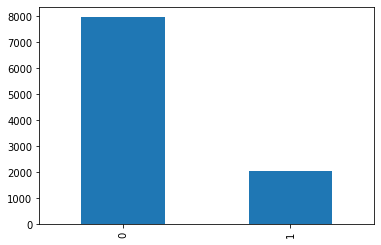

In [4]:
X.Exited.value_counts().plot(kind='bar')

In [5]:
geography = pd.get_dummies(X.Geography, drop_first=True)
gender = pd.get_dummies(X.Gender, drop_first=True)

In [6]:
df = pd.concat([geography, gender, X], axis=1)
df = df.drop(['Geography', 'Gender'], axis=1)

In [7]:
data = df.iloc[:,:-1]
label= df.iloc[:,-1]

In [8]:
data.head()

,Germany,Spain,Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,0,0,619,42,2,0.00,1,1,1,101348.88
1,0,1,0,608,41,1,83807.86,1,0,1,112542.58
2,0,0,0,502,42,8,159660.80,3,1,0,113931.57
3,0,0,0,699,39,1,0.00,2,0,0,93826.63
4,0,1,0,850,43,2,125510.82,1,1,1,79084.10


In [9]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 101,stratify=label)

In [10]:
def f2_make(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [11]:
f2 = make_scorer(f2_make)

In [12]:
def create_model(layers, activation, optimizer, w_initializer):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i ==0:
            model.add(Dense(units=nodes, kernel_initializer= w_initializer, input_dim=X_train.shape[1]))
            model.add(Activation(activation=activation))
        else:
            model.add(Dense(units=nodes, kernel_initializer= w_initializer))
            model.add(Activation(activation=activation))
            
    model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model = KerasClassifier(build_fn=create_model, verbose=0)
model

In [14]:
layers = [[80, 60, 45, 30, 15], [120, 80, 60, 45, 30, 15]]
activations = ['sigmoid', 'relu']
optimizers = ['rmsprop', 'adam']
w_initializers = ['he_uniform']

In [15]:
param_grid = {'mlp__layers':layers, 'mlp__activation':activations, 'mlp__optimizer' : optimizers, 
              'mlp__w_initializer' : w_initializers, 'mlp__batch_size' : [128], 'mlp__epochs':[60,80,120]}

In [16]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', model))

In [17]:
pipeline = Pipeline(estimators)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring=f2, verbose=1)

In [18]:
%%time
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 14.7min finished


Wall time: 14min 56s


In [19]:
[grid_result.best_score_,grid_result.best_params_]

[0.5906856276126778,
 {'mlp__activation': 'sigmoid',
  'mlp__batch_size': 128,
  'mlp__epochs': 60,
  'mlp__layers': [120, 80, 60, 45, 30, 15],
  'mlp__optimizer': 'rmsprop',
  'mlp__w_initializer': 'he_uniform'}]

In [21]:
# Feature Scaling
SC = StandardScaler()
X_train_scaled = SC.fit_transform(X_train)
X_test_scaled = SC.transform(X_test)

In [22]:
model = create_model([120, 80, 60, 45, 30, 15], 'sigmoid', 'rmsprop', 'he_uniform')

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 120)               1440      
_________________________________________________________________
activation_6 (Activation)    (None, 120)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 80)                9680      
_________________________________________________________________
activation_7 (Activation)    (None, 80)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 60)                4860      
_________________________________________________________________
activation_8 (Activation)    (None, 60)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 45)               

In [24]:
history = model.fit(X_train_scaled, y_train, batch_size=128, epochs=60, validation_split=0.1, verbose=2).history

Train on 7200 samples, validate on 800 samples
Epoch 1/60
7200/7200 - 1s - loss: 0.6250 - accuracy: 0.6686 - val_loss: 0.5163 - val_accuracy: 0.8025
Epoch 2/60
7200/7200 - 0s - loss: 0.5098 - accuracy: 0.7956 - val_loss: 0.4971 - val_accuracy: 0.8025
Epoch 3/60
7200/7200 - 0s - loss: 0.5060 - accuracy: 0.7956 - val_loss: 0.4952 - val_accuracy: 0.8025
Epoch 4/60
7200/7200 - 0s - loss: 0.4936 - accuracy: 0.7956 - val_loss: 0.4653 - val_accuracy: 0.8025
Epoch 5/60
7200/7200 - 0s - loss: 0.4562 - accuracy: 0.7956 - val_loss: 0.4288 - val_accuracy: 0.8025
Epoch 6/60
7200/7200 - 0s - loss: 0.4341 - accuracy: 0.7956 - val_loss: 0.4377 - val_accuracy: 0.8163
Epoch 7/60
7200/7200 - 0s - loss: 0.4290 - accuracy: 0.7953 - val_loss: 0.4221 - val_accuracy: 0.8050
Epoch 8/60
7200/7200 - 0s - loss: 0.4269 - accuracy: 0.7949 - val_loss: 0.4144 - val_accuracy: 0.8025
Epoch 9/60
7200/7200 - 0s - loss: 0.4259 - accuracy: 0.7931 - val_loss: 0.4135 - val_accuracy: 0.8000
Epoch 10/60
7200/7200 - 0s - loss: 

In [25]:
pred_y = model.predict(X_test_scaled)
pred_y = (pred_y > 0.5)

In [26]:
#performance on test data
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1593
           1       0.65      0.48      0.55       407

    accuracy                           0.84      2000
   macro avg       0.76      0.71      0.73      2000
weighted avg       0.83      0.84      0.83      2000



In [27]:
#performance on train data
pred_y = model.predict(X_train_scaled)
pred_y = (pred_y > 0.5)
print(classification_report(y_train, pred_y))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6370
           1       0.71      0.58      0.64      1630

    accuracy                           0.87      8000
   macro avg       0.80      0.76      0.78      8000
weighted avg       0.86      0.87      0.86      8000



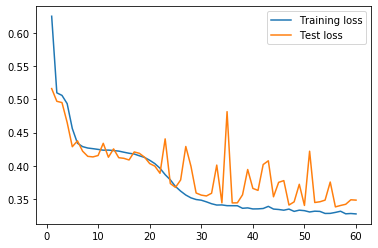

In [29]:
plt.plot(np.arange(1,61), history['loss'], label='Training loss')
plt.plot(np.arange(1,61), history['val_loss'], label='Test loss')
plt.legend()

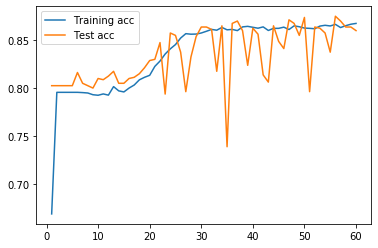

In [30]:
plt.plot(np.arange(1,61), history['accuracy'], label='Training acc')
plt.plot(np.arange(1,61), history['val_accuracy'], label='Test acc')
plt.legend()

In [31]:
# performance is very power, need to apply some sampling.